L'objectif de ce notebook est d'appliquer des méthodes de dé-bruitage d'images et pre-traitement des valeurs manquantes.
A partir de la librairie Sckit-Learn on va trouver les algorithmes suivants :

- Inpainting NS
- Inpainting TELEA

In [ ]:
!gdown https://drive.google.com/uc?id=1G6e681hlmsQTxlUJIMjJmxso9s5L-SgF -O USE_CASE_2.zip

Downloading...
From: https://drive.google.com/uc?id=1G6e681hlmsQTxlUJIMjJmxso9s5L-SgF
To: /content/USE_CASE_2.zip
100% 152M/152M [00:01<00:00, 106MB/s] 


In [ ]:
#!unzip USE_CASE_2.zip

# Image Data Inspection and Visualization

The objective of this notebook is to inspect and visualize the image dataset resulting from the previous preprocessing step.

In [ ]:
# ! pip3 install opencv-contrib-python

In [ ]:
# ! apt-get install ffmpeg libsm6 libxext6  -y

In [ ]:
import numpy as np
import tifffile as tiff
from matplotlib import pyplot as plt
# from utils import stretch_train
import cv2
from sklearn.impute import SimpleImputer
from os.path import join
from osgeo import gdal,gdal_array,osr,ogr
# from utils import array2raster
# %matplotlib notebook

# Functions definition
## Fonction `stretch_train` pour normaliser les données d'entrées dans l'intervalle [0,1]

In [ ]:
def stretch_train(bands,lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands, dtype=np.float32)
    n = bands.shape[len(bands.shape)-1]
    C,D = [],[]
    for i in range(n):
        a = 0
        b = 1
        tmp = bands[...,i]
        tmp = tmp[~np.isnan(tmp)]
        c = np.percentile(tmp, lower_percent)
        C.append(c)
        d = np.percentile(tmp, higher_percent)
        D.append(d)
        t = a + (bands[..., i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[..., i] = t
    return out.astype(np.float32), C, D

## Fonction `array2raster` pour sauvegarder un raster géoréférencé

In [ ]:
def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Define the path of the two images and the training raster that contains the labels

In [ ]:
img1_path = './USE_CASE_2/image_dataset/stacked_bands_sicoval/T31TCJ_20190327T105031_stacked_masked_cropped.tif'
img2_path = './USE_CASE_2/image_dataset/stacked_bands_sicoval/T31TCJ_20190725T105031_stacked_masked_cropped.tif'

training_path = './USE_CASE_2/image_dataset/training_data/sicoval_training.tif'
training_folder = './USE_CASE_2/image_dataset/training_data' 

### First visualize the image using matplotlib

(1967, 2520, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


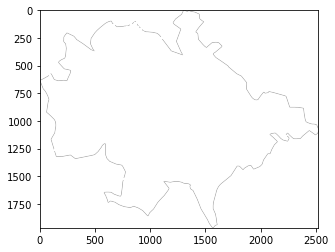

In [ ]:
img1 = tiff.imread(img1_path)
print (img1.shape)
plt.figure(1)
plt.imshow(img1)

In [ ]:
np.unique(img1, return_counts=True)

(array([ 0.,  1.,  9., ..., nan, nan, nan], dtype=float32),
 array([9840036,      14,       1, ...,       1,       1,       1]))

In [ ]:
np.max(img1[~np.isnan(img1)])
# c'est un outlier car la valeur max est 10 000 normalement.

17680.0

### Normalize the image using the 2nd quantile as min and the 98th as max and visualize it again. 
### Note that the fourth band (NIR) acts as an alpha band in matplotlib 

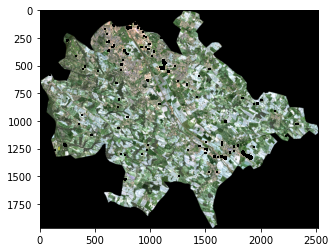

In [ ]:
# pour chaque bande on va trouver le min et le max
norm_img1,_,_ = stretch_train(img1) # stretch = normaliser entre 0 et 1
plt.figure(2)
plt.imshow(norm_img1[...,0:3]) # 0:3 les bandes de couleurs
# si je mets 0:4 il va me dire quel pixel est transparent
plt.show()

In [ ]:
stretch_train(img1)
# on voit que la valeur 17 000 a été supprimé

(array([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         

### Do the same thing with the second image. Inspect the visualization with and without normalization

(1967, 2520, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


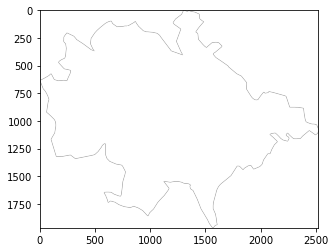

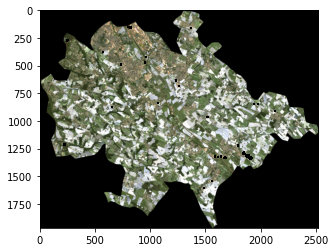

In [ ]:
img2 = tiff.imread(img2_path)
print (img2.shape)
plt.figure(3)
plt.imshow(img2)
norm_img2,_,_ = stretch_train(img2)
plt.figure(4)
plt.imshow(norm_img2[...,0:3])

### Let's visualize the training labels
On a d'abord transformé le shapefile avec les polygones en raster.

(1967, 2520)


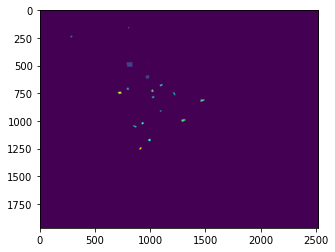

In [ ]:
img_train = tiff.imread(training_path)
print (img_train.shape)
plt.figure(5)
plt.imshow(img_train)

### Can we overlay the labels on one of the two images using matplotlib? This is what will try to do in the following code block

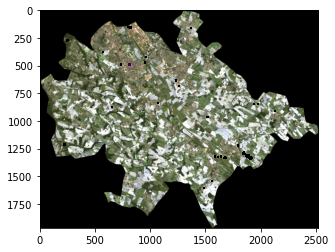

In [ ]:
copy_train = np.copy(img_train).astype(float)
copy_train[copy_train==0] = np.nan
plt.figure(6)
plt.imshow(norm_img2[...,0:3])
plt.imshow(copy_train)
plt.show()

### What can we do with missing data? 
1- One way to deal with missing data is using inpainting methods. These methods aim at replacing missing values using the context of the neighboring pixels in the image.

2- The image itself can be transformed into a 2-D array and the data can be imputed using imputation methods or interpolation.

3- The KNN is not favorable to used in these conditions as there is only two dates and the distance won't be reliable. 

### Let's try first the inpainting methods

In here, we will use the opencv python API to inpaint the missing data in these images. We will compare two methods, the INPAINT NS and the INPAINT TELEA

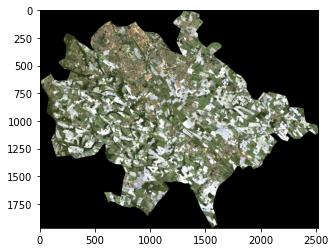

In [ ]:
inpaint2_arr1 = np.zeros_like(norm_img2)
mask = np.isnan(norm_img2).astype(np.uint8)
inpaint2_arr1[...,0] = cv2.inpaint(norm_img2[...,0], mask[...,0],5, cv2.INPAINT_NS)
inpaint2_arr1[...,1] = cv2.inpaint(norm_img2[...,1], mask[...,0],5, cv2.INPAINT_NS)
inpaint2_arr1[...,2] = cv2.inpaint(norm_img2[...,2], mask[...,0],5, cv2.INPAINT_NS)
inpaint2_arr1[...,3] = cv2.inpaint(norm_img2[...,0], mask[...,3],5, cv2.INPAINT_NS)
plt.figure(7)
plt.imshow(inpaint2_arr1[...,0:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


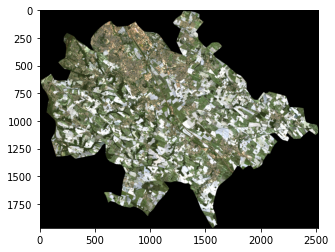

In [ ]:
inpaint2_arr2 = np.zeros_like(norm_img2)
mask = np.isnan(norm_img2).astype(np.uint8)
inpaint2_arr2[...,0] = cv2.inpaint(norm_img2[...,0], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint2_arr2[...,1] = cv2.inpaint(norm_img2[...,1], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint2_arr2[...,2] = cv2.inpaint(norm_img2[...,2], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint2_arr2[...,3] = cv2.inpaint(norm_img2[...,0], mask[...,3],5, cv2.INPAINT_TELEA)
plt.figure(8)
plt.imshow(inpaint2_arr2[...,0:3])

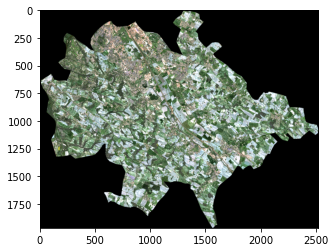

In [ ]:
inpaint1_arr1 = np.zeros_like(norm_img1)
mask = np.isnan(norm_img1).astype(np.uint8)
inpaint1_arr1[...,0] = cv2.inpaint(norm_img1[...,0], mask[...,0],5, cv2.INPAINT_NS)
inpaint1_arr1[...,1] = cv2.inpaint(norm_img1[...,1], mask[...,0],5, cv2.INPAINT_NS)
inpaint1_arr1[...,2] = cv2.inpaint(norm_img1[...,2], mask[...,0],5, cv2.INPAINT_NS)
inpaint1_arr1[...,3] = cv2.inpaint(norm_img1[...,0], mask[...,3],5, cv2.INPAINT_NS)
plt.figure(9)
plt.imshow(inpaint1_arr1[...,0:3])

### Let's try imputation with the mean value of the band

For this we will be using the sklearn library

(1967, 2520, 4)
(4956840, 4)


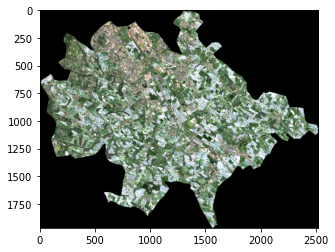

In [ ]:
imputed_arr1 = np.copy(norm_img1)
print (imputed_arr1.shape)
imputed_arr1 = np.reshape(imputed_arr1,(imputed_arr1.shape[0]*imputed_arr1.shape[1],imputed_arr1.shape[2]))
print (imputed_arr1.shape)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_arr1 = imp.fit_transform(imputed_arr1)
imputed_arr1 = np.reshape(imputed_arr1,norm_img1.shape)
plt.figure(10)
plt.imshow(imputed_arr1[...,0:3])


(1967, 2520, 4)
(4956840, 4)


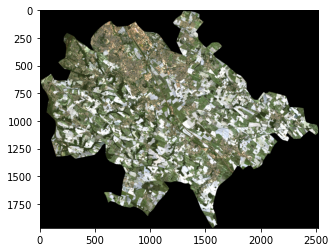

In [ ]:
imputed_arr2 = np.copy(norm_img2)
print (imputed_arr2.shape)
imputed_arr2 = np.reshape(imputed_arr2,(imputed_arr2.shape[0]*imputed_arr2.shape[1],imputed_arr2.shape[2]))
print (imputed_arr2.shape)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_arr2 = imp.fit_transform(imputed_arr2)
imputed_arr2 = np.reshape(imputed_arr2,norm_img2.shape)
plt.figure(11)
plt.imshow(imputed_arr2[...,0:3])

In [ ]:
inpainted_img1_path = join(training_folder,'inpainted_img1.tif')
inpainted_img2_path = join(training_folder,'inpainted_img2.tif')

# la meilleur methode etait avec INPAINT_NS
# Puis on sauvegarde les images avec la fonction array2raster
dataset = gdal.Open(img1_path)
#array2raster(inpainted_img1_path,dataset,inpaint1_arr1,'Float32')

dataset = gdal.Open(img2_path)
#array2raster(inpainted_img2_path,dataset,inpaint2_arr1,'Float32')